In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [6]:
data = pd.read_excel('online_retail.xlsx')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
print('Shape of the excel sheet is ', data.shape)
display('There are missing data in columns ', data.isna().sum())
data.dropna()

print('we dropped them')


Shape of the excel sheet is  (525461, 8)


'There are missing data in columns '

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

we dropped them


In [8]:
# featuring engineering and handling missing values
import datetime as dt

data['Ammount'] = data['Price']*data['Quantity']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.strftime('%b')
data['Year'] = data['InvoiceDate'].dt.strftime('%Y')
data['Hour'] = data['InvoiceDate'].dt.strftime('%H')

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Ammount,Month,Year,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,Dec,2009,07
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Dec,2009,07
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Dec,2009,07
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,Dec,2009,07
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,Dec,2009,07


## Recency, Frequency, Monetary 
We are able to create these aggregates in order to classify a customers profile base on their RFM score. From that score we will then be able to train a ML model to predict customer profitablity over time 

* Recency - Calculated as number of days since last purchase
* Frequency - Number of transactions over a given time period
* Monetary - Ammount spent over that given period of time 

These will be the ngrouped in terms of percentages

To calculate Recency we can take the differnce of the day after the last day in our dataset and the invoice date. That will give us the relative number or days since last purchase. 

In [9]:
last_day = data['InvoiceDate'].max()+dt.timedelta(days=1)  # last day in df + 1 day

# creating the group me and aggregating RFM
cust_RFM = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (last_day - x.max()).days,  # creates the Recency by applying a lambda function to take the difference of each individual invoice row 
    'Invoice': 'count',
    'Ammount':'sum'
}).reset_index()

# renaming the columns to RFM
cust_RFM.rename(columns={'InvoiceDate':'Recency', 'Invoice':'Frequency', 'Ammount':'Monetary'}, inplace=True)
print('The shape of the grouped columns', cust_RFM.shape)
cust_RFM.head()

The shape of the grouped columns (4383, 4)


,Customer ID,Recency,Frequency,Monetary
0,12346.0,67,46,-64.68
1,12347.0,3,71,1323.32
2,12348.0,74,20,222.16
3,12349.0,43,107,2646.99
4,12351.0,11,21,300.93


Now that we have our RFM Score we can visualize the distributions and from that we can divide scores into individual quartiles 

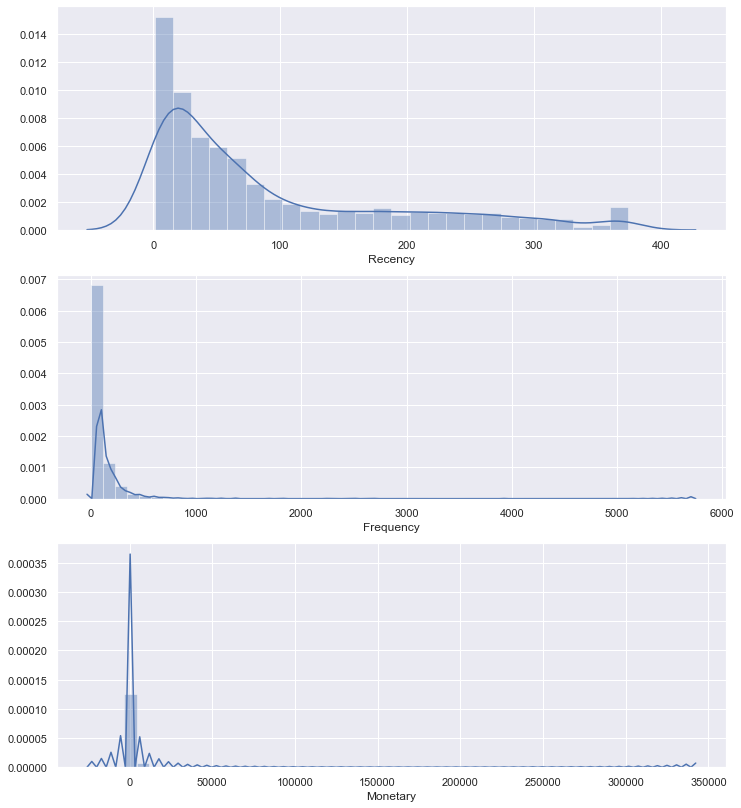

In [10]:
fig, ax = plt.subplots(3,1, figsize=(12,14))
sns.distplot(cust_RFM['Recency'], ax=ax[0])
sns.distplot(cust_RFM['Frequency'], ax=ax[1])
sns.distplot(cust_RFM['Monetary'], ax=ax[2])

In [11]:
# Scaling the data and dealing with outliers 
print(cust_RFM.describe())

        Customer ID      Recency    Frequency       Monetary
count   4383.000000  4383.000000  4383.000000    4383.000000
mean   15350.611453    91.395163    95.262149    1904.679118
std     1700.737934    98.176493   204.903882    8519.369281
min    12346.000000     1.000000     1.000000  -25111.090000
25%    13880.500000    17.000000    18.000000     285.260000
50%    15354.000000    52.000000    44.000000     655.940000
75%    16837.000000   138.000000   103.000000    1645.690000
max    18287.000000   374.000000  5710.000000  341776.730000


Here we see very skewed data, pretty large range we'll have to account for in scaling when we do ML, and also outliers that will have an affect on our models we will have to account for 

In [12]:
# using z-score standardization to remove outliers greater than 3* greater than the standard deviation
from scipy import stats


In [18]:
zscore_custRFM = cust_RFM[(np.abs(stats.zscore(cust_RFM)) < 3)]
z

In [13]:
zscore_custRFM = cust_RFM[(np.abs(stats.zscore(cust_RFM.drop('Customer ID', axis =1, inplace=True))) < 3).all(axis=1)]
zscore_custRFM.describe()

IndexError: tuple index out of range

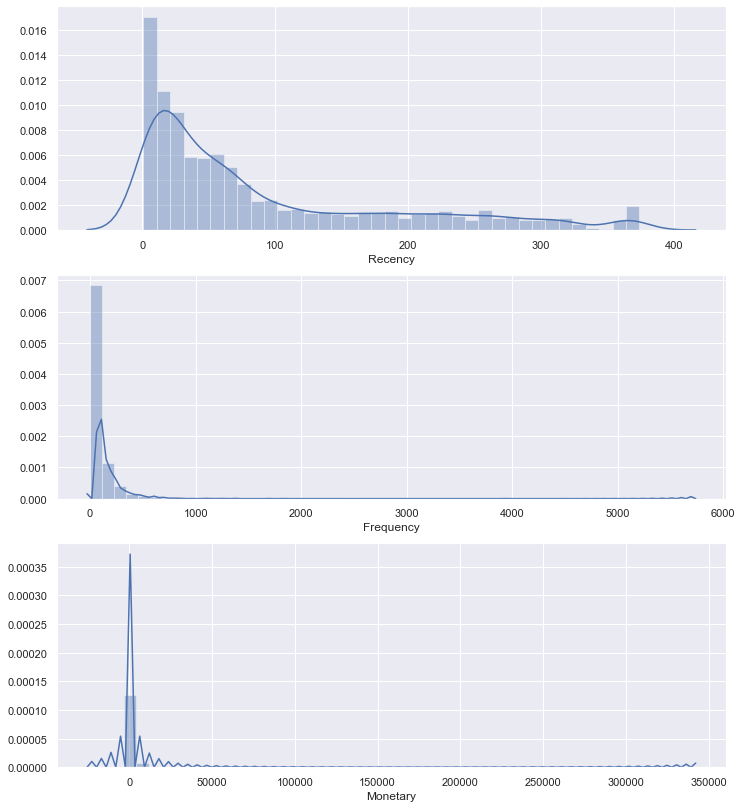

In [19]:
fig, ax = plt.subplots(3,1, figsize=(12,14))
sns.distplot(zscore_custRFM['Recency'], ax=ax[0])
sns.distplot(zscore_custRFM['Frequency'], ax=ax[1])
sns.distplot(zscore_custRFM['Monetary'], ax=ax[2])

Here we can see some normalization of the distributions however there are still significant outliers. Lets try standardizing using scikit learns preprocessing and try combining.

In [20]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [21]:
names = cust_RFM.columns

scaled_custRFM = scaler.fit_transform(cust_RFM)
scaled_custRFM = pd.DataFrame(scaled_custRFM, columns=names)
scaled_custRFM.describe()

,Recency,Frequency,Monetary
count,4.383000e+03,4.383000e+03,4.383000e+03
mean,8.288044e-17,5.909854e-18,-1.393003e-17
std,1.000114e+00,1.000114e+00,1.000114e+00
min,-9.208465e-01,-4.600835e-01,-3.171461e+00
25%,-7.578561e-01,-3.771083e-01,-1.901084e-01
50%,-4.013146e-01,-2.502051e-01,-1.465932e-01
75%,4.747588e-01,3.776763e-02,-3.040350e-02
max,2.878867e+00,2.740494e+01,3.989859e+01


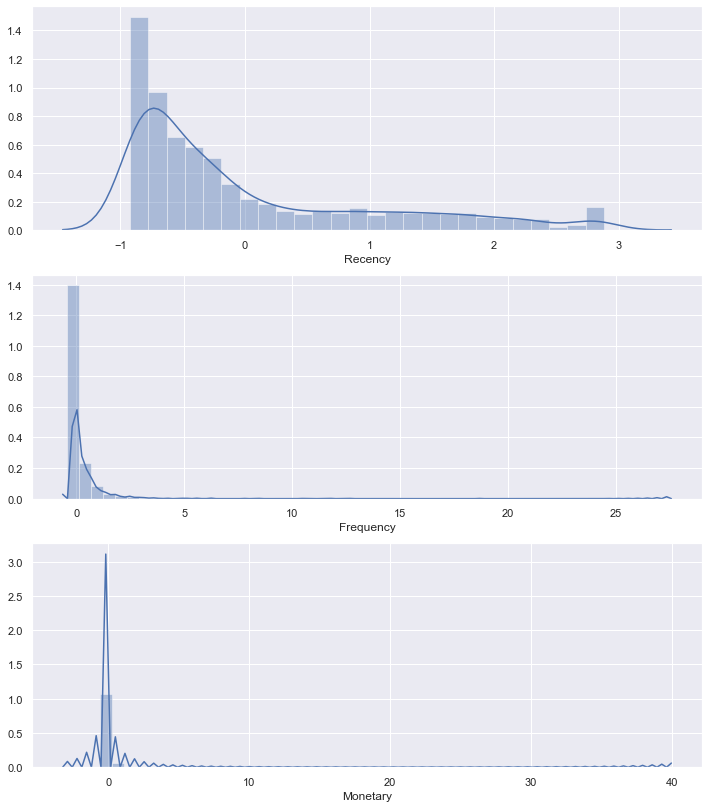

In [22]:
fig, ax = plt.subplots(3,1, figsize=(12,14))
sns.distplot(scaled_custRFM['Recency'], ax=ax[0])
sns.distplot(scaled_custRFM['Frequency'], ax=ax[1])
sns.distplot(scaled_custRFM['Monetary'], ax=ax[2])

## KMeans Classification

In [23]:
import sklearn 
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [24]:
k = 3  # here we will try to divide our group into 3 groups
samples, features = scaled_custRFM.shape

X_train, x_test, y_train, y_test = train_test_split()

ValueError: At least one array required as input

In [ ]:
# creating a function to score our model taken sklearn docs

def bench_k_means(estimator, name, data):
    estimator.fit(data)
    print('%-9s\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, estimator.inertia_,
             metrics.homogeneity_score(y, estimator.labels_),
             metrics.completeness_score(y, estimator.labels_),
             metrics.v_measure_score(y, estimator.labels_),
             metrics.adjusted_rand_score(y, estimator.labels_),
             metrics.adjusted_mutual_info_score(y,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean')))
    

In [ ]:
#training the model 
clf = KMeans(n_clusters=k, n_init=10, max_iter=300)
bench_k_means(clf, '1', scaled_custRFM)

In [ ]:
# trying to find rfm by month
cust_month = data.groupby(['Month', 'Customer ID']).agg({
    'InvoiceDate': lambda x: (last_day - x.max()).days,  # creates the Recency by applying a lambda function to take the difference of each individual invoice row 
    'Invoice': 'count',
    'Ammount':'sum'
}).reset_index()

cust_month.rename(columns={'InvoiceDate':'Recency', 'Invoice':'Frequency', 'Ammount':'Monetary'}, inplace=True)
# print('The shape of the grouped columns', cust_month.shape)
cust_month.head()

for i in cust_month
# for i in range(1,13):
#     print(i)

In [ ]:
data.dtypes